In [ ]:
#Block A
from matplotlib.colors import Normalize
from PIL import Image
from scipy.io import wavfile
from scipy.signal import spectrogram
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
#from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ViT_B_16_Weights, vit_b_16
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0
from tqdm import tqdm

import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import shutil
import torch
import torch.nn as nn
import torch.optim as optim

1. Data Understanding and Pre-processing
a. Explore dataset to understand structure and duration


In [ ]:
#Block B
# Define a dictionary to map ship types to labels
ship_type_to_label = {
    #"kaiyuan": 0,
    "other": 0,
    "speedboat": 1,
    "uuv": 2
}
#kaiyuan doesn't work because there isn't file that has the name kaiyuan in it?
os.makedirs("spectrograms", exist_ok=True)
for ship_type in ship_type_to_label.keys():
  os.makedirs(os.path.join("spectrograms", "train", ship_type), exist_ok=True)
  os.makedirs(os.path.join("spectrograms", "val", ship_type), exist_ok=True)

# Get all audio files
audio_files = glob.glob('*.wav')


In [ ]:
#Block C
#Parameters
freq_min = 10
freq_max = 2500
window_size = 1024
overlap = 800
n_fft = 1024 * 4

1b. Convert raw audio into spectrograms
1c. normalize and resize spectrogram images


In [ ]:
#Block D
# Process audio files
random.shuffle(audio_files)
split_ratio = 0.8
split_index = int(len(audio_files) * split_ratio)
train_files = audio_files[:split_index]
val_files = audio_files[split_index:]
for i, file_path in enumerate(audio_files):
# Extract ship type from filename using regular expression
  match = re.search(r'(uuv|speedboat|other)', file_path, re.IGNORECASE)
  if match:
    ship_type = match.group(1).lower()  # Get the matched ship type and convert to lowercase
  else:
    ship_type= "other"
  label = ship_type_to_label[ship_type]  # Get the corresponding label
  #print(file_path)
  fs, x = wavfile.read(file_path)
  f, t, S = spectrogram(x, fs, nperseg = window_size, noverlap=overlap, nfft = n_fft)
  f_mask = (f >= freq_min) & (f <= freq_max)
  sxx = S[f_mask, :]
  G = 10* np.log10(sxx + 1e-8)

  # Determine output folder based on ship type
  folder = "train" if i <split_index else "val"
  output_filename = os.path.join("spectrograms", folder, ship_type, os.path.basename(file_path).replace('.wav', '.png'))
  G_resized.save(output_filename)
  #output_file = os.path.join(output_folder, os.path.basename(file_path).replace('.wav', '.png'))
  #G_resized.save(output_file)
  #else:
  #  print(f"Warning: Could not determine ship type for file: {file_path}")

Kaiyuan class doesn't work because no file has the word kaiyuan in it. All the Kaiyuans have speedboat so the files from the kaiyuan dataset go to the speedboat class.

1d. visualize example spectrograms for different ship types and background noise


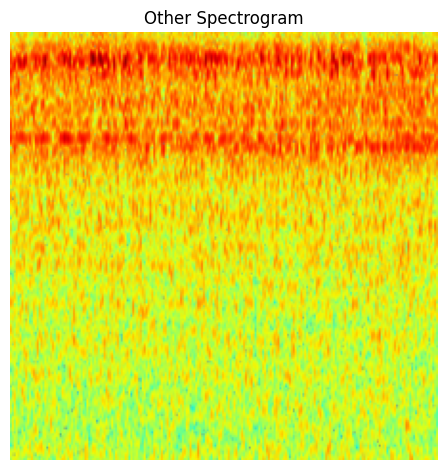

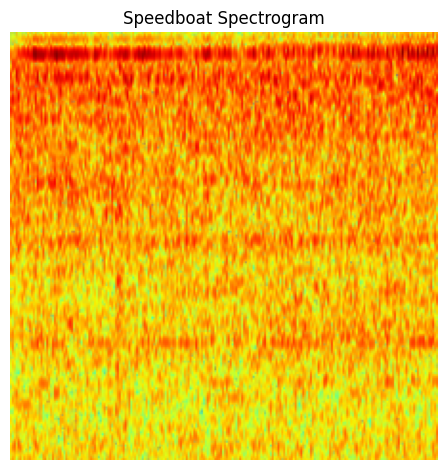

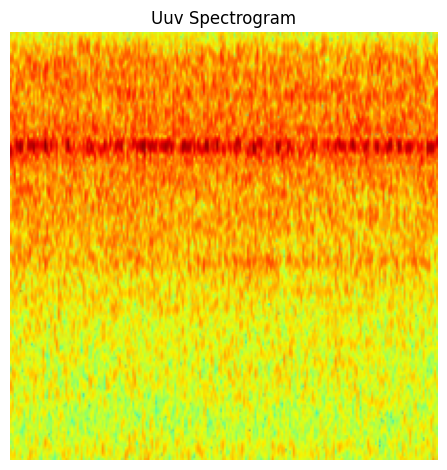

In [ ]:
#Block E
# Define ship types
ship_types = ["other", "speedboat", "uuv"]
# Define a function to plot a spectrogram
def plot_spectrogram(image_path, title):
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

# Plot spectrograms for each ship type
for ship_type in ship_types:
    # Get a random audio file for the ship type
  spectrogram_files = glob.glob(os.path.join("spectrograms", "train", ship_type, '*.png'))
  if spectrogram_files:
    random_spectrogram = random.choice(spectrogram_files)
    plot_spectrogram(random_spectrogram, f"{ship_type.capitalize()} Spectrogram")
  # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
  else:
    print(f"No spectrograms found for ship type: {ship_type}")


Create model for Training

Prepare Data

In [ ]:
#Block F
#parameters
batch_size = 8
num_epochs = 1
learning_rate = 0.001
#num_classes = 4
num_classes = 3
print(num_classes)


3


In [ ]:
#Block G
# Create datasets and data loaders for each ship type
train_dataset = {}
val_dataset = {}
train_loader = {}
val_loader = {}
#image transformations
transform = transforms.Compose([transforms.ToTensor()])
#ship_types = ["kaiyuan", "other", "speedboat", "uuv"]
ship_types = ["other", "speedboat", "uuv"]
spectrogram_root = "spectrograms"
for ship_type in ship_types:
  train_dir = os.path.join(spectrogram_root, "train")
  val_dir = os.path.join(spectrogram_root, "val")
  #Image folder datasets
  train_dataset[ship_type] = datasets.ImageFolder(train_dir, transform=transform)
  val_dataset[ship_type] = datasets.ImageFolder(val_dir, transform=transform)
  train_loader[ship_type] = DataLoader(train_dataset[ship_type], batch_size=batch_size, shuffle=True)
  val_loader[ship_type] = DataLoader(val_dataset[ship_type], batch_size=batch_size, shuffle=False)


3a. Implement transformer-based model for classifying ship types using spectrogram inputs

In [ ]:
#Block H
class ViTModel(nn.Module):
  def __init__(self, num_classes):
    super(ViTModel, self).__init__()
    #Load pretrained Vistion Transformer model
    self.model = models.vit_b_16(pretrained=True)
    #Replace the head (classification layer)
    in_features = self.model.heads.head.in_features
    self.model.heads.head = nn.Linear(in_features, num_classes)

  def forward(self, x):
    return self.model(x)

2. a. Design CNN model for classifying ship types based on spectrograms

In [ ]:
#Block I
class EfficientNetModel(nn.Module):
  def __init__(self, num_classes):
    super(EfficientNetModel, self).__init__()
    self.model = models.efficientnet_b0(pretrained=True)
    self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

  def forward(self, x):
    return self.model(x)

Initialize Models, loss function, and optimizer

In [ ]:
#Block J

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#vit_model = ViTModel(num_classes).to(device)
#vit_model = ViT_B_16_Weights.DEFAULT.transforms()
vit_model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT).to(device)
#efficientnet_model = EfficientNetModel(num_classes).to(device)
efficientnet_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)
criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.Adam(vit_model.parameters(), lr=learning_rate)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=learning_rate)

2b. train CNN model on spectrograms 2c. evaluate performance using accuracy, precision, recall, and confusion matrix

In [ ]:
#Block K
#def train_model(model, optimizer, train_loader, val_loader, num_epochs, dataset_name, model_name):
def train_model(model, optimizer, train_loader, val_loader, num_epochs, model_name):
  all_predicted = []
  all_labels = []
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Training {model_name} Epoch {epoch+1}/{num_epochs}"):
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*inputs.size(0)
    train_loss /= len(train_loader.dataset)

    #Validation phase
    model.eval()
    #all_predicted = []
    #all_labels = []
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #val_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        #For validation accuracy calculation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        val_loss += loss.item()*inputs.size(0)

        #For other metrics calculation
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

      val_loss /= len(val_loader.dataset)
      val_accuracy = 100 * correct / total
    print(f"{model_name} Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  return all_predicted, all_labels

Train Vision Transformer and EfficientNet on all 4 datasets


In [ ]:
#Block L
#UUV - VIT
all_predicted, all_labels = train_model(vit_model, vit_optimizer, train_loader["uuv"], val_loader["uuv"], num_epochs, "ViT")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for UUV- VIT:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")

Training ViT Epoch 1/1:  23%|██▎       | 100/443 [29:50<1:43:50, 18.16s/it]

In [ ]:
#Bloc M
#UUV EFF
all_predicted, all_labels = train_model (efficientnet_model, efficientnet_optimizer, train_loader["uuv"], val_loader["uuv"], num_epochs, "EfficientNet")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for UUV- EFF:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")

In [ ]:
#Bloc N
#speedboat VIT
all_labels, all_predicted = train_model(vit_model, vit_optimizer, train_loader["speedboat"], val_loader["speedboat"], num_epochs, "ViT")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for Speedboat VIT:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")

In [ ]:
#Bloc O
#speedboat EFF
all_labels, all_predicted = train_model (efficientnet_model, efficientnet_optimizer, train_loader["speedboat"], val_loader["speedboat"], num_epochs, "EfficientNet")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for Speedboat EFF:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")

In [ ]:
#Block P
#other VIT
all_labels, all_predicted = train_model(vit_model, vit_optimizer, train_loader["other"], val_loader["other"], num_epochs, "ViT")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for Other VIT:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")

In [ ]:
#Bloc Q
#other EFF
all_labels, all_predicted = train_model (efficientnet_model, efficientnet_optimizer, train_loader["other"], val_loader["other"], num_epochs, "EfficientNet")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for Other EFF:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")



In [ ]:
#Block R
#Kaiyuan VIT
"""
all_labels, all_predicted = train_model(vit_model, vit_optimizer, train_loader["kaiyuan"], val_loader["kaiyuan"], num_epochs, "ViT")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for Kaiyuan VIT:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")
"""

In [ ]:
#Bloc S
#Kaiyuan EFF
"""
all_labels, all_predicted = train_model (efficientnet_model, efficientnet_optimizer, train_loader["kaiyuan"], val_loader["kaiyuan"], num_epochs, "EfficientNet")
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)
  #results[(model_name, dataset_name)] = (all_predicted, all_labels)
print(f"Results for Kaiyuan EFF:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Confusion Matrix: {conf_matrix}")
"""

4.
Compare the classification results of the CNN and Transformer models:
Discuss which model performed better and why.
Highlight strengths and weaknesses of each model in the context of underwater acoustic signal classification.

Could not get any accuracies. Would need that to compare.

5. Discuss the role of spectrograms in this classification task.
Reflect on the challenges faced in preprocessing, model training, and evaluation.
Provide recommendations for future work, including possible enhancements to the models.

Role of spectrograms is to classify a type of ship according to its sound, converted to an image. Spectrograms become the dataset from audio files. Challenges are getting the right data to the right folders and training and testing right files in the right formats. Recommendations are more epochs, higher batch size, and different optimizers. But without accuracies working it doesn't make a difference.